In [72]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import datetime, warnings, scipy
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from scipy import stats as st

#import pandas
from keras.models import Sequential
from keras.layers import Dense # fully connected layers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
import datetime
from datetime import date
from datetime import datetime
import winsound

In [ ]:
pd.options.display.max_columns = 50

### Pre process

In [2]:
### Preprocess

flights_train = pd.read_csv('Data/flights_train.csv', index_col=0)
flights_test = pd.read_csv('Data/flights_test.csv', index_col=0)

airlines = pd.read_csv('Data/airlines.csv', index_col=0)
airports = pd.read_csv('Data/airports.csv', index_col=0)

C:\Users\Paula\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
def conv_to_time(column):
    s = column.astype(int).astype(str).str.zfill(4)
    #add : twice
    column = s.str[:2] + ':' + s.str[2:] + ':00'
    
    return column

In [4]:
def add_dep_delay(scheduled,depart):
    
    tdelta = []
    FMT = '%H:%M:%S'

    for i in range(0,len(scheduled)):
        tdelta.append(datetime.strptime(depart.iloc[i], FMT) -
                      datetime.strptime(scheduled.iloc[i], FMT))


    for i in range(0,len(tdelta)):
        if (scheduled.iloc[i].startswith("00") & depart.iloc[i].startswith("23"))== True:
            tdelta[i] = timedelta(
            days=tdelta[i].days,
            seconds= tdelta[i].seconds - 24*60*60,
            microseconds=tdelta[i].microseconds
        )
        elif (scheduled.iloc[i].startswith("23") & depart.iloc[i].startswith("0"))==True:
            tdelta[i] = timedelta(
            days=0,
            seconds= tdelta[i].seconds,
            microseconds=tdelta[i].microseconds
        )
        if tdelta[i].days < 0:
            tdelta[i] = (tdelta[i].seconds - 24*60*60)/60
        else:
            tdelta[i] = (tdelta[i].seconds)/60

    return tdelta

In [5]:
flights_train["DEPARTURE_TIME1"]  = conv_to_time(flights_train["DEPARTURE_TIME"])
flights_train["SCHEDULED_DEPARTURE1"]  = conv_to_time(flights_train["SCHEDULED_DEPARTURE"])

flights_train["DEPARTURE_TIME1"] = flights_train["DEPARTURE_TIME1"].replace('24:00:00','00:00:00')

flights_train["DEPARTURE_DELAY"] = add_dep_delay(flights_train["SCHEDULED_DEPARTURE1"],flights_train["DEPARTURE_TIME1"])

flights_train.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DEPARTURE_TIME1,SCHEDULED_DEPARTURE1,DEPARTURE_DELAY
id,,,,,,,,,,,,,,,,,,,,
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0,23:54:00,00:05:00,-11.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0,00:02:00,00:10:00,-8.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0,00:18:00,00:20:00,-2.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0,00:15:00,00:20:00,-5.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0,00:24:00,00:25:00,-1.0


In [6]:
flights_test["DEPARTURE_TIME1"]  = conv_to_time(flights_test["DEPARTURE_TIME"])
flights_test["SCHEDULED_DEPARTURE1"]  = conv_to_time(flights_test["SCHEDULED_DEPARTURE"])

flights_test["DEPARTURE_TIME1"] = flights_test["DEPARTURE_TIME1"].replace('24:00:00','00:00:00')

flights_test["DEPARTURE_DELAY"] = add_dep_delay(flights_test["SCHEDULED_DEPARTURE1"],flights_test["DEPARTURE_TIME1"])

### Loading Datasets

In [215]:
train_set = pd.read_csv('Data/merged_flights.csv', index_col=0)
train_set

C:\Users\Paula\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DEPARTURE_DELAY,SPEED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Count Flights,Enplanements,area
0,2015-01-01,4,AS,N407AS,ANC,SEA,00:05:00,23:54:00,21.0,00:15:00,205.0,1448,04:30:00,-22.0,-11.0,423.805,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
1,2015-01-01,4,AS,N309AS,ANC,SEA,00:45:00,00:41:00,17.0,00:58:00,204.0,1448,05:09:00,-14.0,-4.0,425.882,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
2,2015-01-01,4,DL,N3743H,ANC,SEA,00:45:00,00:31:00,25.0,00:56:00,210.0,1448,05:15:00,-24.0,-14.0,413.714,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
3,2015-01-01,4,AS,N413AS,ANC,PDX,00:50:00,00:46:00,11.0,00:57:00,215.0,1542,05:25:00,-18.0,-4.0,430.326,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
4,2015-01-01,4,US,N804AW,ANC,PHX,01:52:00,01:43:00,21.0,02:04:00,323.0,2552,09:15:00,-10.0,-9.0,474.056,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015-06-25,4,B6,N306JB,HYA,JFK,13:09:00,13:15:00,9.0,13:24:00,72.0,196,14:21:00,-12.0,6.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south
2818549,2015-06-26,5,B6,N298JB,HYA,JFK,13:09:00,13:15:00,5.0,13:20:00,72.0,196,14:21:00,-18.0,6.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south
2818550,2015-06-27,6,B6,N316JB,HYA,JFK,13:09:00,13:08:00,16.0,13:24:00,72.0,196,14:21:00,-7.0,-1.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south
2818551,2015-06-29,1,B6,N274JB,HYA,JFK,13:09:00,13:05:00,6.0,13:11:00,72.0,196,14:21:00,-22.0,-4.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south


In [144]:
test_set = pd.read_csv('Data/test_set.csv', index_col=0)
test_set.head()

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY,SPEED,ARRIVAL_DELAY
id,,,,,,,,,,,,,,,,
0,2015-07-01,3,NK,N624NK,LAS,IAH,00:03:00,00:41:00,11.0,00:52:00,177.0,1222,05:00:00,38.0,414.237,0
1,2015-07-01,3,AA,N507AY,SFO,CLT,00:05:00,00:00:00,21.0,00:21:00,303.0,2296,08:08:00,-5.0,454.653,0
2,2015-07-01,3,DL,N3759,LAX,MEM,00:05:00,00:00:00,36.0,00:36:00,223.0,1619,05:48:00,-5.0,435.605,0
3,2015-07-01,3,NK,N629NK,LAS,MSP,00:05:00,00:53:00,14.0,01:07:00,178.0,1299,05:03:00,48.0,437.865,0
4,2015-07-01,3,UA,N39418,ANC,ORD,00:08:00,00:17:00,20.0,00:37:00,364.0,2846,09:12:00,9.0,469.121,0


### Load Pickles

In [19]:
flights_train = pd.read_pickle('flights_train.pickle')
flights_test = pd.read_pickle('flights_test.pickle')

In [31]:
flights_train.to_csv("flights_train.csv")
flights_test.to_csv("flights_test.csv")

### Features

We keep columns:
* Month
* Day of week
* Airline
* Origin airport
* Destination airport
* Scheduled time
* Distance
* Departure delay

### Encoding

Category columns:
* Airline
* Origin airport
* Destination airport
* Day of week
* Month

We will try applying TARGET Encoding to non-numeric columns:
* Airline
* Origin airport
* Destination airport

In [20]:
def drop_cols(df, cols):
    df = df.drop(cols, axis=1)
    return df

In [22]:
# Drop the unnecessary cols
cols = ['SCHEDULED_ARRIVAL', 'TAXI_OUT', 'YEAR', 'DAY', 'TAIL_NUMBER', 'DEPARTURE_TIME', 'WHEELS_OFF', 'DEPARTURE_TIME1', 'SCHEDULED_DEPARTURE1', 'SCHEDULED_TIME']

train_set = drop_cols(flights_train, cols)
test_set = drop_cols(flights_test, cols)

display(train_set.head(1), train_set.shape)
display(test_set.head(1), test_set.shape)

,MONTH,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,ARRIVAL_DELAY,DEPARTURE_DELAY
id,,,,,,,,,,
0,1,4,AS,98,ANC,SEA,5,1448,-22.0,-11.0


(2818553, 10)

,MONTH,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,DEPARTURE_DELAY
id,,,,,,,,,
0,7,3,NK,298,LAS,IAH,3,1222,38.0


(514384, 9)

In [23]:
def target_encoding(df, target_encode_columns: list, target: list):
    target_encode_df = df[target_encode_columns + target].reset_index().drop(columns = 'id', axis = 1)
    target_name = target[0]
    target_df = pd.DataFrame()
    encoding_vals = {}
    for embed_col in target_encode_columns:
        val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
        target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
        encoding_vals[embed_col] = val_map
    score_target_drop = df.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'id', axis = 1)
    score_target = pd.concat([score_target_drop, target_df], axis = 1)
    
    return score_target, encoding_vals

In [24]:
def test_encoding(df, encoding_vals):
    target_encode_columns = [col for col in encoding_vals.keys()]
    target_encode_df = df[target_encode_columns].reset_index().drop(columns = 'id', axis = 1)
    target_df = pd.DataFrame()
    for embed_col in encoding_vals.keys():
        val_map = encoding_vals[embed_col]
        target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    score_target_drop = df.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'id', axis = 1)
    score_target = pd.concat([score_target_drop, target_df], axis = 1)
    return score_target

In [27]:
target_encode_columns = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'MONTH', 'DAY_OF_WEEK']
target = ['ARRIVAL_DELAY']
train, encoding_vals = target_encoding(train_set, target_encode_columns, target)

X_train =train.drop(columns=['ARRIVAL_DELAY'])
Y_train = train['ARRIVAL_DELAY']

X_test = test_encoding(test_set, encoding_vals)

display(X_train.shape, X_train.dtypes)
display(X_test.shape, X_test.dtypes)

(2818553, 9)

FLIGHT_NUMBER            int64
SCHEDULED_DEPARTURE      int64
DISTANCE                 int64
DEPARTURE_DELAY        float64
AIRLINE                float64
ORIGIN_AIRPORT         float64
DESTINATION_AIRPORT    float64
MONTH                  float64
DAY_OF_WEEK            float64
dtype: object

(514384, 9)

FLIGHT_NUMBER            int64
SCHEDULED_DEPARTURE      int64
DISTANCE                 int64
DEPARTURE_DELAY        float64
AIRLINE                float64
ORIGIN_AIRPORT         float64
DESTINATION_AIRPORT    float64
MONTH                  float64
DAY_OF_WEEK            float64
dtype: object

# XGBoost

https://keras.io/api/layers/regularizers/

In [28]:
import xgboost as xgb

In [29]:
xgb.DMatrix?

In [14]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

In [17]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

XGBoostError: [13:05:47] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:120: label must be in [0,1] for logistic regression

In [8]:
# Define the model

model = xgb.XGBRegressor()

# model = xgb.XGBRegressor(
#             n_estimators=1000, #int -> Number of gradient boosted trees.  Equivalent to number of boosting rounds.
#             max_depth=7, # Optional[int] -> Maximum tree depth for base learners.
#             eta=0.1, #learning_rate : Optional[float] -> Boosting learning rate (xgb's "eta")
#             subsample=0.7, # Optional[float] -> Subsample ratio of the training instance.
#             colsample_bytree=0.8 # Optional[float] -> Subsample ratio of columns when constructing each tree.
#         )
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

Model evaluation method: **Repeated K-Fold cross validator.**


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html

In [70]:
# define model evaluation method
cv = RepeatedKFold(
            n_splits=10, # int, default=5 Number of folds. Must be at least 2.
            n_repeats=3, # int, default=10 Number of times cross-validator needs to be repeated.
            random_state=1 # int, RandomState instance or None, default=None 
#                           Controls the randomness of each repeated cross-validation instance. Pass an int for reproducible output across multiple function calls. See Glossary.
    )



In [ ]:
# evaluate model
scores = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

### XGBoost with Random Grid Search


In [30]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)
params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive
}

#Find the best parameters
model_xgb = xgb.XGBRegressor(nthread=-1) 
        # nthread: [default to maximum number of threads available if not set] Number of parallel threads used to run XGBoost. When choosing it, please keep thread contention and hyperthreading in mind.
rsCV = RandomizedSearchCV(model_xgb, params, n_jobs=1)  
rsCV.fit(X_train, Y_train)
rsCV.best_params_, rsCV.best_score_

winsound.Beep(440, 1000)

KeyboardInterrupt: 

In [ ]:
model_xgb_best = xgb.XGBRegressor(**rsCV.best_params_)
model_xgb_best.fit(X_train, Y_train)

winsound.Beep(440, 1000)

In [ ]:
predictions = model_xgb_best.predict(X_test)
#print("MSE: %.4f" % mean_squared_error(yval, clf.predict(xval)))

winsound.Beep(440, 1000)

In [206]:
predictions.shape

(514384,)

### XGBoost with K-fold

To build more robust models with XGBoost, we should always perform k-fold cross validation.

In this way, we ensure that the original training dataset is used for both training and validation.

Also, each entry is used for validation just once.

XGBoost supports k-fold cross validation using the cv() method.

In [205]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=Ytrain)

SyntaxError: unexpected EOF while parsing (<ipython-input-205-482f09398cb5>, line 2)

In [ ]:
params_cv = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5,
          'alpha': 10
         }

xgb_cv = xgb.cv(dtrain=data_dmatrix,
                params=params_cv,
                nfold=3,
                num_boost_round=50,
                early_stopping_rounds=10,
                metrics="auc",
                as_pandas=True,
                seed=123
               )

xgb_cv.head()

# xgb_cv.best_params_, xgb_cv.best_score_

**Feature importance with XGBoost**

XGBoost provides a way to examine the importance of each feature in the original dataset within the model.
It involves counting the number of times each feature is split on across all boosting trees in the model.

Then we can visualize the features that has been given the highest important score among all the features.

In [ ]:
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()

### Kaggle Submission Format

In [210]:
pd.DataFrame(predictions).to_csv("submission_xgb.csv")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

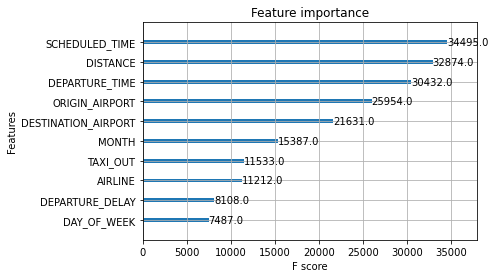

In [207]:
xgb.plot_importance(model_xgb_best)

In [208]:
X_train

,DAY_OF_WEEK,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,DISTANCE,DEPARTURE_DELAY,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MONTH
0,4,2354.0,21.0,205.0,1448,-11.0,-1.104695,-0.774214,1.326610,1
1,4,41.0,17.0,204.0,1448,-4.0,-1.104695,-0.774214,1.326610,1
2,4,31.0,25.0,210.0,1448,-14.0,1.694466,-0.774214,1.326610,1
3,4,46.0,11.0,215.0,1542,-4.0,-1.104695,-0.774214,1.966414,1
4,4,143.0,21.0,323.0,2552,-9.0,3.706209,-0.774214,3.088939,1
...,...,...,...,...,...,...,...,...,...,...
2818548,4,1315.0,9.0,72.0,196,6.0,6.968689,18.833333,9.525048,6
2818549,5,1315.0,5.0,72.0,196,6.0,6.968689,18.833333,9.525048,6
2818550,6,1308.0,16.0,72.0,196,-1.0,6.968689,18.833333,9.525048,6
2818551,1,1305.0,6.0,72.0,196,-4.0,6.968689,18.833333,9.525048,6


### Saving model

In [99]:
# save model and architecture to single file
# model_xgb_best.save("model_9.h5")
# save to JSON
model_xgb.save_model("model_xgb.json")
# save to text format
model_xgb.save_model("model_xgb.txt")
print("Saved model to disk")

NotFittedError: need to call fit or load_model beforehand

In [27]:
new_predictions = loaded_model.predict(X_test)
print(new_predictions)

[[ 40.38021  ]
 [-10.870261 ]
 [ -9.2564535]
 ...
 [ -3.8454266]
 [  5.260379 ]
 [ -0.757607 ]]


#### Save file for Kaggle submition

In [28]:
pd.DataFrame(new_predictions).to_csv("submission_9.csv")


In [140]:
X_train

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,DISTANCE,DEPARTURE_DELAY,MONTH
0,4,AS,ANC,SEA,2354.0,21.0,205.0,1448,-11.0,1
1,4,AS,ANC,SEA,41.0,17.0,204.0,1448,-4.0,1
2,4,DL,ANC,SEA,31.0,25.0,210.0,1448,-14.0,1
3,4,AS,ANC,PDX,46.0,11.0,215.0,1542,-4.0,1
4,4,US,ANC,PHX,143.0,21.0,323.0,2552,-9.0,1
...,...,...,...,...,...,...,...,...,...,...
2818548,4,B6,HYA,JFK,1315.0,9.0,72.0,196,6.0,6
2818549,5,B6,HYA,JFK,1315.0,5.0,72.0,196,6.0,6
2818550,6,B6,HYA,JFK,1308.0,16.0,72.0,196,-1.0,6
2818551,1,B6,HYA,JFK,1305.0,6.0,72.0,196,-4.0,6
